# Lab 08 – Distances and PCA

**DUE: Feb 21, 2024 (Wednesday)**  

Pair Programming: Optional, but highly encouraged

Name(s): Samuel Baldwin  
Class: CSCI 349 - Intro to Data Mining  
Section: 01 
Semester: Spring 2024
Instructors: Brian King, Joshua Stough


# Objectives
* Practice more `pandas`
* Use chi-squared test to evaluate two categorical variables for independence
* Learn about implementing distance matrices
* Learn how to employ PCA
* A bit more with visualizations

# Partnerships
I'm encouraging you to consider working with a partner. It's not required yet, but you are strongly encouraged to do so. If the material is complex to you, talking out what you are doing with a partner can have tremendous benefits. And, if you do, both partners must be listed in the top cell above.

# Directions
Work through this lab, and enter the answers to questions that are scattered throughout this lab. It is quite likely you'll need to add additional imports as you work through the lab. Just add them to the top cell if you use them. Most expected imports are added for you already.



In [32]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

---
**1)**	[P] Set up a pandas data frame with the following 8 observations and 3 variables.

```
   test1      test2  test3
A0     A  excellent     25
A1     C       fair     32
A2     C       good     60
A3     B       fair     53
A4     A       poor     23
A5     B  excellent     37
A6     C       good     45
A7     B       good     49
```

Be sure to set the types of each variable as follows:
* `test1`: Nominal, levels = { "A", "B", C" }
* `test2`: Ordinal, levels = { "poor", "fair", "good", "excellent" }
* `test3`: Numeric

Use `pd.Categorical` for the nominal and ordinal variables (and pay attention to the `ordered` parameter.) Name the data frame `df`. Set the `index` correctly to match the row names in the table above.

Display the `df` data frame, and then show the output of `df.info()` to show the type of each variable in `df`.

In [33]:
# ANSWER
data = {
    'test1': ['A', 'C', 'C', 'B', 'A', 'B', 'C', 'B'],
    'test2': ['excellent', 'fair', 'good', 'fair', 'poor', 'excellent', 'good', 'good'],
    'test3': [25, 32, 60, 53, 23, 37, 45, 49]
}

df = pd.DataFrame(data)
df.index = ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7']
levels = { "A", "B", "C" }
df['test1'] = pd.Categorical(df['test1'], categories=levels, ordered=True)
levels = { "poor", "fair", "good", "excellent" }
df['test2'] = pd.Categorical(df['test2'], categories=levels, ordered=True)
df['test1'] = df['test1'].cat.reorder_categories(['A', 'B', 'C'])
df['test2'] = df['test2'].cat.reorder_categories(['poor', 'fair', 'good', 'excellent'])
print(df)
print(df.info())



   test1      test2  test3
A0     A  excellent     25
A1     C       fair     32
A2     C       good     60
A3     B       fair     53
A4     A       poor     23
A5     B  excellent     37
A6     C       good     45
A7     B       good     49
<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, A0 to A7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   test1   8 non-null      category
 1   test2   8 non-null      category
 2   test3   8 non-null      int64   
dtypes: category(2), int64(1)
memory usage: 480.0+ bytes
None


---
**2)**	[MP] Show the output of `df.describe(include='all')`. What does the `include='all'` parameter do?

In [34]:
# ANSWER
df.describe(include='all')

,test1,test2,test3
count,8,8,8.000000
unique,3,4,NaN
top,B,good,NaN
freq,3,3,NaN
mean,NaN,NaN,40.500000
std,NaN,NaN,13.416408
min,NaN,NaN,23.000000
25%,NaN,NaN,30.250000
50%,NaN,NaN,41.000000
75%,NaN,NaN,50.000000


**ANSWER:**
The include = 'all'  parameter makes it so instead of just providing the summary statistics for the numerical values, the summary statistics are provided for all columns, including the categorical ones.


---
**3)**	[PM] Show the output of `df.test1.cat.categories`, and `df.test2.cat.categories`. What is this showing? Does it work for `df.test3.cat.categories`?

In [35]:
# ANSWER
print(df.test1.cat.categories)
print(df.test2.cat.categories)

Index(['A', 'B', 'C'], dtype='object')
Index(['poor', 'fair', 'good', 'excellent'], dtype='object')


**ANSWER:** These calls show the categories of a given column in df. df.test3.cat.categories does not work, as the .cat accessor accesses the categories for a specified column. The first and second calls work as test1 and test2 are categorical in some way and therefore have categories that it can show, but given that the third is numerical, it doesn't have categories and therefore throws an error. 



---
**4)**	[PM] Show the output of `df.test1.cat.codes`, and `df.test2.cat.codes`. What is this showing?

In [36]:
# ANSWER
print(df.test1.cat.codes)
print(df.test2.cat.codes)

A0    0
A1    2
A2    2
A3    1
A4    0
A5    1
A6    2
A7    1
dtype: int8
A0    3
A1    1
A2    2
A3    1
A4    0
A5    3
A6    2
A7    2
dtype: int8


**ANSWER:** The category codes that are shown are the index position of each categorical variable by row. For example test1.cat.codes will show the index of the value in test1 wrt the categories in that column. 0 is the first position or A, 1 is the second or B, and so forth. 

---
**5)** [P] Report the counts of each level of the categorical variables.

In [37]:
# ANSWER
print(df['test1'].value_counts())
print(df['test2'].value_counts())

test1
B    3
C    3
A    2
Name: count, dtype: int64
test2
good         3
fair         2
excellent    2
poor         1
Name: count, dtype: int64


---
**6)** [P] Report a cross tabulation (i.e. contingency table) between `test1` and `test2`. Include the margins (i.e. the sum of the rows and the columns) in your reported table (HINT: Look up pandas `crosstab()` function).

Your results should look something like this:

```
test2  poor  fair  good  excellent  All
test1
A         1     0     0          1    2
B         0     1     1          1    3
C         0     1     2          0    3
All       1     2     3          2    8
```


In [38]:
# ANSWER
pd.crosstab(df['test1'], df['test2'], margins=True)



test2,poor,fair,good,excellent,All
test1,,,,,
A,1,0,0,1,2
B,0,1,1,1,3
C,0,1,2,0,3
All,1,2,3,2,8


---
**7)** [P] From the previous table, store the contingency table without the margins in a variable called `observed`

In [39]:
# ANSWER

observed = pd.crosstab(df['test1'], df['test2'])

---
**8)** [P] Run a chi-squared test for independence using the contingency table from the previous step. Clearly report the chi2 statistic, the p value, and the degrees of freedom, and then use the p-value to clearly state whether `test1` and `test2` are independent in your Python code (no markdown).

In [40]:
# ANSWER

chi2, p, degrees , exp = stats.chi2_contingency(observed)
print(f'The chi2 is {round(chi2,3)}, the p-value is {round(p,3)} and the degrees of freedom is {degrees}. Given the p-value of {round(p,3)} which is greater than 0.05 we can state that that test1 and test2 are independent')

The chi2 is 6.444, the p-value is 0.375 and the degrees of freedom is 6. Given the p-value of 0.375 which is greater than 0.05 we can state that that test1 and test2 are independent


---
Now, you're going to explore some similarities between observations. Yes, this is a SMALL dataset! (Don't bother to explore large data until you can understand how they work on small, toy experimental data!)

Before you can compute a pairwise distance matrix to report the distance between all pairs of observations, always remember that **you can only compute distances between strictly numeric data.** Therefore, you must convert your data to numeric types for ALL variables you want to include in your distance metric.

---
**9)** Create a new data frame called `df_num` that represents a numeric version of the above. Do NOT do any rescaling of your variables yet!

NOTE: If you do this from a dataframe that has the categorical variables set up properly, then this step is simple to do. The two choices I generally follow are either:

   1. use the cat member of your categorical data, which stores a `CategoricalAccessor` object (look it up), or
   2. use one of the encoders in the `sklearn.preprocessing` module.

The first option is easier, and yet another reason why it's so important to take the time to preprocess your data as correctly and error-free as possible.

If you do it correctly, your resulting dataframe should look something like this:
```
    test1  test2  test3
A0      0      3     25
A1      2      1     32
A2      2      2     60
A3      1      1     53
A4      0      0     23
A5      1      3     37
A6      2      2     45
A7      1      2     49
```

In [41]:
# ANSWER
from sklearn.preprocessing import LabelEncoder
df_num = pd.DataFrame()

df_num['test2'] = df['test2'].astype('category').cat.codes
df_num['test1'] = df['test1'].astype('category').cat.codes
df_num['test3'] = df['test3']

---
**10)** [P] As you learned in lecture, you absolutely must rescale your data to fall on a similar scale for most methods to be meaningful. There are different approaches to doing so. A standardized zscore is among the most common, but not necessarily always the best approach, especially when you are dealing with numeric representations of true categorical data. Rescaling your data to all fall between 0 and 1 is also a common approach, particularly when you have categorical data.

Let's first try to rescale our data to all fall between the values of 0 and 1. Use the `MinMaxScaler` in `sklearn.preprocessing` to rescale all variables to fall between 0 and 1. Store the transformed data as a pandas data frame called `df_num_zeroone`. Your result should look as follows:

```
    test1     test2     test3
A0    0.0  1.000000  0.054054
A1    1.0  0.333333  0.243243
A2    1.0  0.666667  1.000000
A3    0.5  0.333333  0.810811
A4    0.0  0.000000  0.000000
A5    0.5  1.000000  0.378378
A6    1.0  0.666667  0.594595
A7    0.5  0.666667  0.702703
```



In [42]:
# ANSWER
scaler = MinMaxScaler()
df_num_zeroone = df_num
df_num_zeroone['test1'] = scaler.fit_transform(df_num_zeroone['test1'].values.reshape(-1,1))
df_num_zeroone['test2'] = scaler.fit_transform(df_num_zeroone['test2'].values.reshape(-1,1))
df_num_zeroone

,test2,test1,test3
A0,1.000000,0.0,25
A1,0.333333,1.0,32
A2,0.666667,1.0,60
A3,0.333333,0.5,53
A4,0.000000,0.0,23
A5,1.000000,0.5,37
A6,0.666667,1.0,45
A7,0.666667,0.5,49


---
**11)**	Notice the value of `test3`. It's OK, but there are times we have solid knowledge of what we expect our range to be. We can (and usually should) rescale our data using that knowledge. In the case of `test3`, suppose that you learned that the data must fall between 0 and 100.

Reassign `test3` so that the min and max before rescaling are assuming to be between 0 and 100, respectively. (i.e. simply divide the original variable by 100!)

In [43]:
# ANSWER
df_num_zeroone['test3'] = df_num_zeroone['test3']/100
df_num_zeroone


,test2,test1,test3
A0,1.000000,0.0,0.25
A1,0.333333,1.0,0.32
A2,0.666667,1.0,0.60
A3,0.333333,0.5,0.53
A4,0.000000,0.0,0.23
A5,1.000000,0.5,0.37
A6,0.666667,1.0,0.45
A7,0.666667,0.5,0.49


---
**12)**	[P] Compute a single distance matrix called `distmat_zeroone`. Use a standard Euclidean distance measure. Your reported result should be an 8x8 matrix with appropriately labeled rows and columns. (HINT – study the output of the distance matrix functions. They do not output a square matrix. As discussed in lecture you can use either `pairwise_distances` from scikit-learn, or the `pdist` and `squareform` functions in `scipy.spatial.distance`). Be sure to label the rows and columns to be the index from the input dataframe. Round it to 3 significant digits.

Your result should look something like this...
```
       A0     A1     A2     A3     A4     A5     A6     A7
A0  0.000  1.204  1.111  0.879  1.000  0.514  1.073  0.647
A1  1.204  0.000  0.435  0.542  1.058  0.835  0.358  0.625
A2  1.111  0.435  0.000  0.605  1.258  0.643  0.150  0.512
A3  0.879  0.542  0.605  0.000  0.672  0.686  0.606  0.336
A4  1.000  1.058  1.258  0.672  0.000  1.127  1.222  0.873
A5  0.514  0.835  0.643  0.686  1.127  0.000  0.606  0.354
A6  1.073  0.358  0.150  0.606  1.222  0.606  0.000  0.502
A7  0.647  0.625  0.512  0.336  0.873  0.354  0.502  0.000
```

In [44]:
# ANSWER
from sklearn.metrics.pairwise import pairwise_distances
matrix = pairwise_distances(df_num_zeroone, metric='euclidean')
distmat_zeroone = pd.DataFrame(matrix, index=df.index, columns=df.index)
distmat_zeroone = distmat_zeroone.round(3)
distmat_zeroone

,A0,A1,A2,A3,A4,A5,A6,A7
A0,0.000,1.204,1.111,0.879,1.000,0.514,1.073,0.647
A1,1.204,0.000,0.435,0.542,1.058,0.835,0.358,0.625
A2,1.111,0.435,0.000,0.605,1.258,0.643,0.150,0.512
A3,0.879,0.542,0.605,0.000,0.672,0.686,0.606,0.336
A4,1.000,1.058,1.258,0.672,0.000,1.127,1.222,0.873
A5,0.514,0.835,0.643,0.686,1.127,0.000,0.606,0.354
A6,1.073,0.358,0.150,0.606,1.222,0.606,0.000,0.502
A7,0.647,0.625,0.512,0.336,0.873,0.354,0.502,0.000


---
**13)**	[P] Output the top three closest (i.e. most similar) pairs of observations. You MUST write Python code to report these results! Do not simply print out your distance matrix and tell me your answers! Consider that this may have been thousands of observations! Always generate reported answers in code!

For each pair, output the pair of observations from the original dataframe and the distance between them.

(HINT: I actaully found this easiest to do with the output of `pdist` with the `sorted` function.)

Your first closest pair output might have output that looks something like this:

```
Closest: # 0 : ['A2', 'A6'] dist=0.150
   test1 test2  test3
A2     C  good     60
A6     C  good     45
```


In [45]:
# ANSWER:
upper = np.triu(distmat_zeroone, k=1)
vals = sorted(upper.flatten())
vals = sorted([value for value in vals if value  > 0])
for i in range(0,3):
    row, col = np.argwhere(vals[i] == distmat_zeroone)
    first = "\t".join(map(str, df.iloc[row[0]].values))
    second = "\t".join(map(str, df.iloc[row[1]].values))
    cols ="\t".join(map(str, df.columns.values))
    print(f"Closest: #{i}: ['{df.index[row[0]]}','{df.index[row[1]]}'] dist={vals[i]}\n\t{cols}\n{df.index[row[0]]}\t{first}\n{df.index[row[1]]}\t{second}")
    

Closest: #0: ['A2','A6'] dist=0.15
	test1	test2	test3
A2	C	good	60
A6	C	good	45
Closest: #1: ['A3','A7'] dist=0.336
	test1	test2	test3
A3	B	fair	53
A7	B	good	49
Closest: #2: ['A5','A7'] dist=0.354
	test1	test2	test3
A5	B	excellent	37
A7	B	good	49


---
**14)**	[P] Output the three observations that are *least similar*, with the two most distant observations output first. Again, for each pair, output the two observations, and the distance between them

In [46]:
# ANSWER
upper = np.triu(distmat_zeroone, k=1)
vals = sorted(upper.flatten())
vals = sorted([value for value in vals if value  > 0])
for i in range(len(vals)-3,len(vals)):
    row, col = np.argwhere(vals[i] == distmat_zeroone)
    first = "\t".join(map(str, df.iloc[row[0]].values))
    second = "\t".join(map(str, df.iloc[row[1]].values))
    cols ="\t".join(map(str, df.columns.values))
    print(f"Furthest: #{i} : ['{df.index[row[0]]}','{df.index[row[1]]}'] dist={vals[i]}\n\t{cols}\n{df.index[row[0]]}\t{first}\n{df.index[row[1]]}\t{second}")
    


Furthest: #25 : ['A0','A1'] dist=1.204
	test1	test2	test3
A0	A	excellent	25
A1	C	fair	32
Furthest: #26 : ['A4','A6'] dist=1.222
	test1	test2	test3
A4	A	poor	23
A6	C	good	45
Furthest: #27 : ['A2','A4'] dist=1.258
	test1	test2	test3
A2	C	good	60
A4	A	poor	23


---
**15)**	[P] Create a new data frame, `df_num_binarized`, that stores a *binarized* version for `test1` and `test2`. The variable `test3` is already numeric, scaled to fall between 0 and 1 already. So, once you've created `df_num_binarized`, then copy the variable `test3` from `df_num_zeroone` to `df_num_binarized`.

(HINT: Remember, `pd.get_dummies` makes this quite easy to do, or you could use `OneHotEncoder` from `sklearn.preprocessing` and set `sparse=False, dtype=int`)

Your first row might look something like the following:
```
    test1_A  test1_B  test1_C  test2_poor  test2_fair  test2_good  test2_excellent  test3
A0        1        0        0           0           0           0                1   0.25
```


In [47]:
# ANSWER
df_num_binarized = pd.get_dummies(df, columns=['test1', 'test2'], prefix=['test1','test2']).astype(int)
df_num_binarized['test3'] = df_num_zeroone['test3']
df_num_binarized


,test3,test1_A,test1_B,test1_C,test2_poor,test2_fair,test2_good,test2_excellent
A0,0.25,1,0,0,0,0,0,1
A1,0.32,0,0,1,0,1,0,0
A2,0.60,0,0,1,0,0,1,0
A3,0.53,0,1,0,0,1,0,0
A4,0.23,1,0,0,1,0,0,0
A5,0.37,0,1,0,0,0,0,1
A6,0.45,0,0,1,0,0,1,0
A7,0.49,0,1,0,0,0,1,0


---
**16)**	[P] Now, compute `distmat_binarized` by computing the distance matrix for the df_binarized.

In [48]:
# ANSWER
matrix = pairwise_distances(df_num_binarized, metric='euclidean')
distmat_binarized = pd.DataFrame(matrix, index=df.index, columns=df.index)
distmat_binarized = distmat_binarized.round(3)
distmat_binarized

,A0,A1,A2,A3,A4,A5,A6,A7
A0,0.000,2.001,2.030,2.020,1.414,1.419,2.010,2.014
A1,2.001,0.000,1.442,1.430,2.002,2.001,1.420,2.007
A2,2.030,1.442,0.000,2.001,2.034,2.013,0.150,1.418
A3,2.020,1.430,2.001,0.000,2.022,1.423,2.002,1.415
A4,1.414,2.002,2.034,2.022,0.000,2.005,2.012,2.017
A5,1.419,2.001,2.013,1.423,2.005,0.000,2.002,1.419
A6,2.010,1.420,0.150,2.002,2.012,2.002,0.000,1.415
A7,2.014,2.007,1.418,1.415,2.017,1.419,1.415,0.000


---
**17)**	[P] Report the three closest pairs, and the three most distant pairs from distmat_binarized

In [67]:
# ANSWER

upper = np.triu(distmat_binarized, k=1)
vals = sorted(upper.flatten())
vals = sorted([value for value in vals if value  > 0])
for i in range(0,3):
    indices = np.argwhere(vals[i] == distmat_binarized)    
    first = "\t".join(map(str, df.iloc[indices[i]].values))
    second = "\t".join(map(str, df.iloc[indices[i]].values))
    cols ="\t".join(map(str, df.columns.values))
    print(f"Closest: #{i}: ['{df.index[row[0]]}','{df.index[row[1]]}'] dist={vals[i]}\n\t{cols}\n{df.index[row[0]]}\t{first}\n{df.index[row[1]]}\t{second}")


for i in range(len(vals)-3,len(vals)):
    indices = np.argwhere(vals[i] == distmat_binarized)
    first = "\t".join(map(str, df.iloc[indices[0]].values))
    second = "\t".join(map(str, df.iloc[indices[1]].values))
    cols ="\t".join(map(str, df.columns.values))
    print(f"Furthest: #{i} : ['{df.index[row[0]]}','{df.index[row[1]]}'] dist={vals[i]}\n\t{cols}\n{df.index[row[0]]}\t{first}\n{df.index[row[1]]}\t{second}")

Closest: #0: ['A2','A4'] dist=0.15
	test1	test2	test3
A2	['C' 'good' 60]	['C' 'good' 45]
A4	['C' 'good' 60]	['C' 'good' 45]
Closest: #1: ['A2','A4'] dist=1.414
	test1	test2	test3
A2	['A' 'poor' 23]	['A' 'excellent' 25]
A4	['A' 'poor' 23]	['A' 'excellent' 25]
Closest: #2: ['A2','A4'] dist=1.415
	test1	test2	test3
A2	['B' 'good' 49]	['B' 'fair' 53]
A4	['B' 'good' 49]	['B' 'fair' 53]
Furthest: #25 : ['A2','A4'] dist=2.022
	test1	test2	test3
A2	['B' 'fair' 53]	['A' 'poor' 23]
A4	['A' 'poor' 23]	['B' 'fair' 53]
Furthest: #26 : ['A2','A4'] dist=2.03
	test1	test2	test3
A2	['A' 'excellent' 25]	['C' 'good' 60]
A4	['C' 'good' 60]	['A' 'excellent' 25]
Furthest: #27 : ['A2','A4'] dist=2.034
	test1	test2	test3
A2	['C' 'good' 60]	['A' 'poor' 23]
A4	['A' 'poor' 23]	['C' 'good' 60]


---
**18)**	[M] Take a moment and compare and contrast your results. Which method do you think have the better results? Why? Which variable do you think was the distinguishing player in affecting the different outcomes between both of the above approaches to transforming your data to numeric results? Summarize what would have been the best transformation to make for all three variables.

**ANSWER:**
Generally I would state that the better of the two methods is the second method. This is because instead of treating the categorical variables as numeric, they are treated in such a fashion that better represents their status as categorical. The pure numerical variable was obviously the most influential on the distance and thus transformation to numeric results, but realistically the steps to standardize and establish the variables on a similar scale ultimately was the best transformation for analysis.  


---
**19)**	[P] Load in your next dataset using the following:

`df_car_crashes = sns.load_dataset('car_crashes')`

The dataset is directly downloaded from:
[https://github.com/mwaskom/seaborn-data/blob/master/car_crashes.csv](https://github.com/mwaskom/seaborn-data/blob/master/car_crashes.csv)

So, your first step with any new dataset is to understand your data. What are the variables? What does each observation represent? Sometimes, it's easy to figure out. Just Google! And, sometimes we need to make the best guess regarding our variables. For now, don't worry too much about specifics. This is a very simplified, highly aggregated dataset from much more extensive stats drawn from the [Insurance Institute for Highway Safety](https://www.iihs.org/iihs/topics/t/general-statistics/fatalityfacts/state-by-state-overview) (NOTE - this might make a great repository for some project?)

In [50]:
# ANSWER
df_car_crashes = sns.load_dataset('car_crashes')

---
**20)**	[P] Preprocess your data. Minimally, you should move the state code to become the index for the dataframe, and then drop that column from your dataframe.

In [51]:
# ANSWER
df_car_crashes.set_index('abbrev', inplace=True)
df_car_crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,,
AL,18.8,7.332,5.640,18.048,15.040,784.55,145.08
AK,18.1,7.421,4.525,16.290,17.014,1053.48,133.93
AZ,18.6,6.510,5.208,15.624,17.856,899.47,110.35
AR,22.4,4.032,5.824,21.056,21.280,827.34,142.39
CA,12.0,4.200,3.360,10.920,10.680,878.41,165.63


---
**21)**	[P] Create a new dataframe called `df_car_crashes_zscore` that represents the zscore transformation for `df_car_crashes`. Again, show the first five rows.



In [52]:
# ANSWER
df_car_crashes_zscore = df_car_crashes.apply(zscore)
df_car_crashes_zscore.head(5)

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,,
AL,0.737446,1.168148,0.439938,1.002301,0.277692,-0.580083,0.430514
AK,0.565936,1.212695,-0.211311,0.608532,0.807258,0.943258,-0.022900
AZ,0.688443,0.756709,0.187615,0.459357,1.033141,0.070876,-0.981778
AR,1.619498,-0.483614,0.547408,1.676052,1.951700,-0.337701,0.321125
CA,-0.928653,-0.399524,-0.891763,-0.594276,-0.891968,-0.048418,1.266178


---
**22)**	[P] Create a distance matrix called `distmat_cars` based on the `df_car_crashes_zscore`. Display the entire distance matrix (which will likely be simplified visually due to its size)

In [53]:
# ANSWER
matrix = pairwise_distances(df_car_crashes_zscore, metric='euclidean')
distmat_cars = pd.DataFrame(matrix, index=df_car_crashes_zscore.index, columns=df_car_crashes_zscore.index)
distmat_cars = distmat_cars.round(3)
distmat_cars

abbrev,AL,AK,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
abbrev,,,,,,,,,,,,,,,,,,,,,
AL,0.000,1.849,1.876,2.616,3.450,2.687,4.023,2.427,6.627,2.863,...,2.273,1.760,1.768,4.074,2.984,3.691,4.099,2.659,3.882,1.346
AK,1.849,0.000,1.461,2.962,3.504,2.675,3.720,1.305,5.923,2.014,...,3.031,2.613,1.983,3.820,3.231,3.940,3.874,2.760,4.080,1.794
AZ,1.876,1.461,0.000,2.593,3.873,2.691,4.341,2.323,6.312,2.472,...,1.806,2.414,2.496,3.639,2.565,3.911,3.717,3.095,3.452,1.165
AR,2.616,2.962,2.593,0.000,4.774,4.082,5.512,3.376,7.648,2.723,...,2.756,2.090,2.858,5.376,4.013,4.578,5.501,2.401,5.215,3.105
CA,3.450,3.504,3.873,4.774,0.000,1.382,1.360,2.801,3.725,3.294,...,4.730,2.985,4.199,2.525,2.638,1.212,2.322,5.589,3.094,3.393
CO,2.687,2.675,2.691,4.082,1.382,0.000,2.171,2.349,4.294,2.885,...,3.599,2.450,3.624,1.893,1.580,1.580,1.825,4.943,2.114,2.217
CT,4.023,3.720,4.341,5.512,1.360,2.171,0.000,2.793,3.101,3.490,...,5.401,3.817,4.346,3.070,3.461,2.372,2.500,5.938,3.628,3.900
DE,2.427,1.305,2.323,3.376,2.801,2.349,2.793,0.000,5.107,1.443,...,3.828,2.557,2.171,3.771,3.324,3.389,3.571,3.438,4.038,2.427
DC,6.627,5.923,6.312,7.648,3.725,4.294,3.101,5.107,0.000,5.343,...,7.356,6.231,7.019,3.805,4.899,4.000,3.304,8.419,4.940,6.197


---
**23)**	[P] An interesting way to suggest outliers is to take a distance matrix, aggregate the mean over each row or column, then sort the output in order. Why would this work? Because an observation that is an outlier should have a relatively high mean distance to all other observations! Do this, and output the list in descending order. (HINT: DC should be your largest outlier, listed first.)

In [54]:
# ANSWER
col_means = distmat_cars.mean()
col_means.sort_values(ascending = False)

abbrev
DC    5.265667
ND    5.257275
SC    5.214314
LA    4.767431
MT    4.759843
WV    4.512765
NJ    4.310804
MA    4.197490
MS    4.048392
AR    3.897667
MD    3.749941
MN    3.719706
OK    3.618059
HI    3.591784
SD    3.585235
TX    3.572118
NY    3.531824
CT    3.514098
WI    3.468765
ID    3.440843
PA    3.440608
UT    3.438176
RI    3.434078
WA    3.297020
FL    3.205451
VA    3.156373
OR    3.130471
CA    3.116882
ME    3.105235
NH    3.100922
IA    3.098451
AK    3.091294
MI    3.072784
NE    3.065176
AL    3.033314
DE    3.022000
AZ    2.999824
TN    2.965333
KY    2.964392
NM    2.914961
IN    2.841431
WY    2.839451
VT    2.820118
NC    2.777647
OH    2.746804
MO    2.734431
GA    2.726569
NV    2.627529
CO    2.617373
IL    2.602275
KS    2.573686
dtype: float64

----
**24)**	[M] From this analysis, which 3 states seem to be the outliers?

**ANSWER:**
It appears that DC, ND, and SC are the outliers. 


---
**25)**	[P] OK. Let's explore the data visually. First, using the original, unscaled data frame `df_car_crashes`, create a scatter plot of insurance premiums vs. insurance losses, with total number of accidents as the size of the point. Create a label near to every point representing the two letter state code.

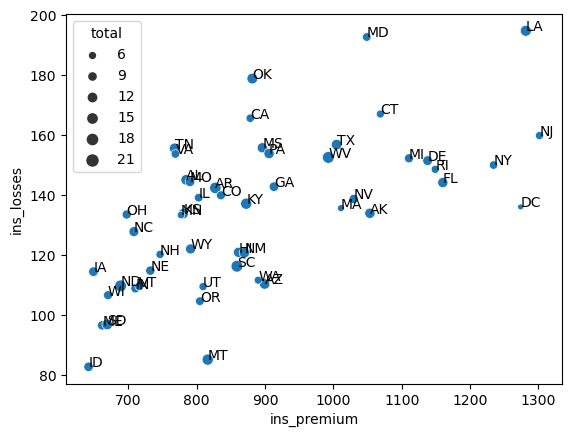

In [55]:
# ANSWER
plot = sns.scatterplot(x = 'ins_premium', y = 'ins_losses', size = 'total', data = df_car_crashes)

for line in range(0, df_car_crashes.shape[0]):
    plot.text(df_car_crashes['ins_premium'][line], df_car_crashes['ins_losses'][line], df_car_crashes.index[line], horizontalalignment='left',
                      size='medium', color='black')

---
**26)** [P] Next, generate **two** plots that show some relationships between variables in the data. Try to use as many variables as you can without creating chaos! Don't just throw in multiple variables for the sake of showing them, only include them if it makes sense to do so. **Your aim is to derive meaning from your data. Good visualizations tell a story.** Strive to use at additional variables as size, as color, or even shape in your data so you can show more than just 2 variables on a single plot. Add titles, legends and label your axes as appropriate.

After each plot, create a markdown cell and briefly draw conclusions from your plot.

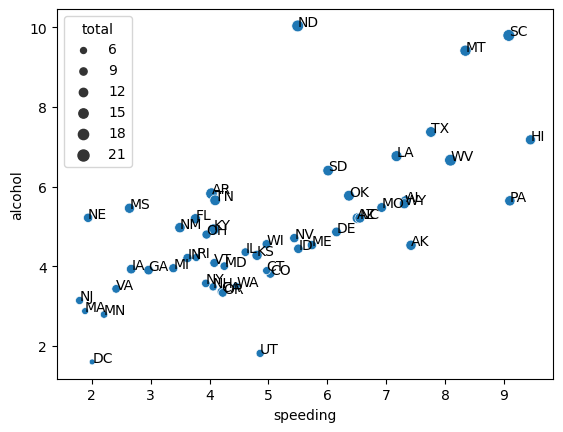

In [56]:
# ANSWER

plot = sns.scatterplot(x = 'speeding', y = 'alcohol', size = 'total', data = df_car_crashes)

for line in range(0, df_car_crashes.shape[0]):
    plot.text(df_car_crashes['speeding'][line], df_car_crashes['alcohol'][line], df_car_crashes.index[line], horizontalalignment='left',
                      size='medium', color='black')

**ANSWER:**
This plot examines the accidents within the context of alcohol and speeding. This shows that there are specific states that have higher levels of alcohol or speeding and the relationships between the two. 



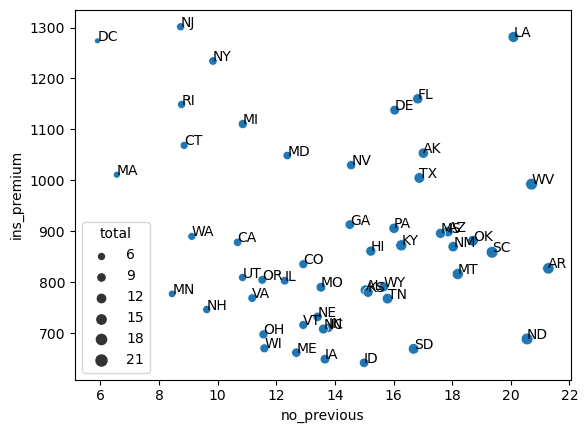

In [57]:
plot = sns.scatterplot(x = 'no_previous', y = 'ins_premium', size = 'total', data = df_car_crashes)

for line in range(0, df_car_crashes.shape[0]):
    plot.text(df_car_crashes['no_previous'][line], df_car_crashes['ins_premium'][line], df_car_crashes.index[line], horizontalalignment='left',
                      size='medium', color='black')

**ANSWER:**
This graph examines how the no_previous and ins_premium variables relate. Realistically, we would expect people with no prior accidents to have a lower insurance premium, something that we see across most states, but there are some specific states that we can look at to demonstrate that there are worse states in which to live in this case.

**27)**	 [P] Now, we're going to look at the data visually, but use a PCA transformation to help give a better sense of trends and differences among our data.

Run a full PCA on the zscore transformed data. Set `n_components` to be the number of variables in the original data. Be sure to fit the data to your PCA model, and then output the components, explained variance, and the explained variance ratio.

In [58]:
# ANSWER
pca = PCA(n_components=df_car_crashes_zscore.shape[1])
pca_output = pca.fit_transform(df_car_crashes_zscore)
print(f"Components: {pca.components_}")
print(f'Explained Varaince: {pca.explained_variance_}')
print(f'Explained Variance Ratio {pca.explained_variance_ratio_}')

Components: [[ 0.47947078  0.37534719  0.45437635  0.4380328   0.45703414 -0.1308319
  -0.06996048]
 [ 0.06893769  0.0765846   0.03345835  0.04237473  0.0961294   0.6852266
   0.71252436]
 [-0.26908802  0.81826935  0.08293253 -0.12616845 -0.31798812  0.25614247
  -0.26173503]
 [ 0.0389558  -0.36374887  0.14834351  0.1712655   0.03948141  0.65639617
  -0.61839859]
 [ 0.14597659 -0.02282818  0.35479821 -0.85646854  0.33611019  0.04214531
  -0.06327152]
 [-0.16970508 -0.22479246  0.7837677   0.08510479 -0.50401185 -0.11577348
   0.17805184]
 [ 0.80082487  0.01784783 -0.15285774 -0.14247844 -0.55875371  0.04126619
  -0.02804966]]
Explained Varaince: [4.0942308  1.6095732  0.56161403 0.35753958 0.2863854  0.20263316
 0.02802383]
Explained Variance Ratio [0.57342168 0.22543042 0.07865743 0.05007557 0.04011    0.02837999
 0.00392491]


---
**28)**	[M] Use your intuition – what do the weights of the first couple of PCs suggest explains most of the variance in the data? Are there certain variables that seem to be more significant? Or are they all playing a role?

**ANSWER:**
Given that the weight of a PC indicates how much a given variable contributes to the construction of the PC, we can examine the components to determine how much each variable influenced each PC. It appears that while each of the variables does contribute to some extent, PC1 and PC2 make up the majority of the influence accounting for almost 80% of the influence. 

---
**29)** [P] Create a plot of the cumulative sum of the explained variance. How many components will get you to 90% of the explained variance?

There is a need for 4 components to get you to 90% of the explained variance


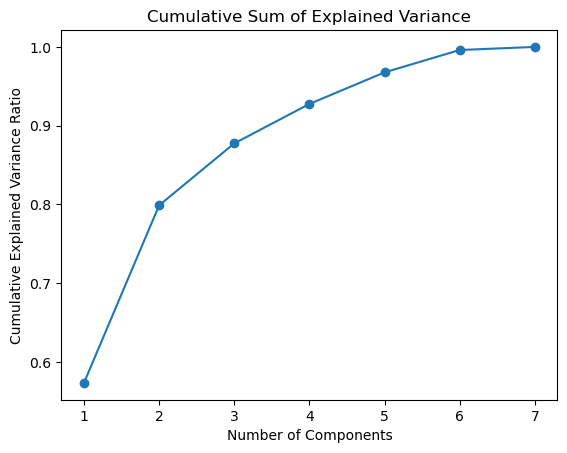

In [59]:
# ANSWER
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1,len(cumulative_variance_ratio)+1), cumulative_variance_ratio, marker = 'o')
plt.title("Cumulative Sum of Explained Variance")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.xlabel("Number of Components")

print(f'There is a need for {(cumulative_variance_ratio >= 0.9).argmax()+1} components to get you to 90% of the explained variance')

---
**30)**	[P] Transform the z_score transformed data using your PCA model (HINT: use the `transform` function of the pca object.)

(NOTE: I often just store the transformed data temporarily as some arbitrary variable, X, to make it easier to manipulate the data for plotting and also use later.)

In [60]:
# ANSWER
x = pca.transform(df_car_crashes_zscore)
x = pd.DataFrame(data = x, columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7'])

---
**31)**	[P] Generate a 2D plot using the first two principal components as your x and y coordinates. Be sure to label each point, and label your axes as component 1 and component 2, respectively.

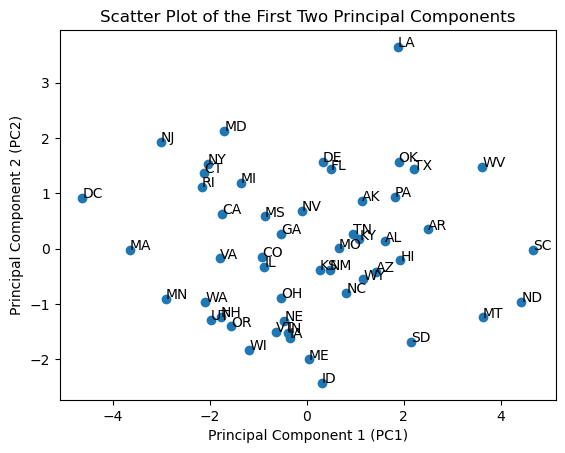

In [61]:
# ANSWER
plt.scatter(x['PC1'], x['PC2'])
for i, index_label in enumerate(df_car_crashes_zscore.index):
    plt.annotate(index_label, (x['PC1'][i], x['PC2'][i]))
plt.title("Scatter Plot of the First Two Principal Components")
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()


---
**32)**	[M] Compare the states you reported as potential outliers above to those that appear to be outliers from your plot. Do the same results seem to hold?

**ANSWER:** It appears that there are some different results. DC, SC, and ND are all still outliers, but not as dramatically as initially indicated. In fact, it appears that the largest outlier in this case is LA. 




---
**33)**	[P] Read how to generate a 3D scatterplot, and use it to generate a scatterplot of the first 3 components.

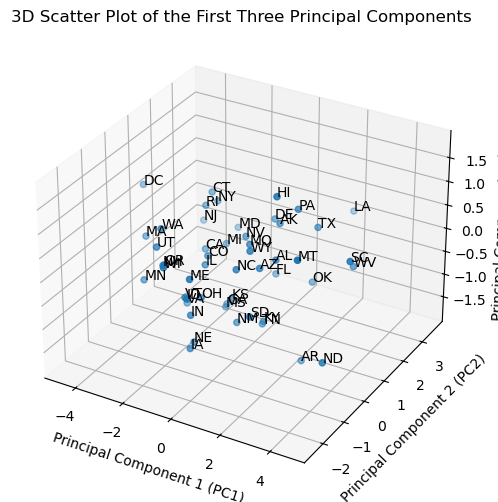

In [62]:
# ANSWER


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x['PC1'], x['PC2'], x['PC3'])

for i, index_label in enumerate(df_car_crashes_zscore.index):
    ax.text(x['PC1'][i], x['PC2'][i], x['PC3'][i], index_label)

ax.set_title('3D Scatter Plot of the First Three Principal Components')
ax.set_xlabel('Principal Component 1 (PC1)')
ax.set_ylabel('Principal Component 2 (PC2)')
ax.set_zlabel('Principal Component 3 (PC3)')

plt.show()



---
**34)**	[M] Do the same outliers still stand out?

**ANSWER:**
Giving the context of the third dimension, it is much easier to see how  DC was an outlier, same for ND. Most likely just as a consequence of the orientation of the graph, it is a bit more difficult to see SC and LA as outliers in this case. 

